# RNN approach to the Upgrade classifier 

This notebook is dedicated to storing my study on a recurrent neural network to classify the track seeds. In these exercises I'll build a model that uses only hits information in order to make a prediction. 

Study roadmap:

1. Import an FT hits data and converts it into time series. This point will be a little bit challenging since hits need to be coded. 
2. Build a model that use LSTM units to classify the tracks
3. Compare the result to the track information NN. 


Open questions:
1. What is the meaning of repetited planeID?

In [289]:
import sys
!{sys.executable} -m pip install --upgrade tmpfile


ERROR: Could not find a version that satisfies the requirement tmpfile (from versions: none)
ERROR: No matching distribution found for tmpfile


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import random
import itertools

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset,ConcatDataset
from torch.autograd import Variable


from timeit import default_timer as timer
from tqdm.notebook import tqdm
from multiprocessing import Pool
import tempfile


In [65]:
! ls /data/work/wessex/Wessex/test/

Brunel_BdJPsiKs_MagU_30k.csv	    FT_Hits.csv
Brunel_track_seeds_with_target.csv  FT_hits_with_info.csv


In [3]:
data = pd.read_csv("/data/work/wessex/Wessex/test/FT_hits_with_info.csv")


In [4]:
data.head(30)

,Unnamed: 0,Unnamed: 0.1,eventID,FT_dxdy,FT_hitPlaneCode,FT_hitzone,FT_lhcbID,FT_particle_key,FT_w,FT_x,FT_z,particle_key,particle_isDown_noVelo
0,0,4,31123,-0.000000,0,1,-1610315668,1518,34.602074,-561.110000,7826.0990,1518,0
1,1,5,31123,0.087489,1,1,-1610248364,1518,34.602074,-579.305500,7895.9000,1518,0
2,2,6,31123,-0.087489,2,1,-1610184504,1518,400.000000,-587.054930,7966.1000,1518,0
3,3,7,31123,-0.087489,2,1,-1610184507,1518,400.000000,-586.302060,7966.0996,1518,0
4,4,8,31123,-0.000000,3,1,-1610117403,1518,34.602074,-605.665000,8035.9010,1518,0
5,5,9,31123,-0.000000,4,1,-1610052948,1518,34.602074,-708.389950,8508.1000,1518,0
6,6,10,31123,0.087489,5,1,-1609986799,1518,34.602074,-727.765400,8577.9000,1518,0
7,7,11,31123,-0.087489,6,1,-1609921781,1518,34.602074,-735.650400,8648.1010,1518,0
8,8,12,31123,-0.000000,7,1,-1609855846,1518,11.890608,-755.310000,8717.9000,1518,0
9,9,13,31123,-0.000000,8,1,-1609790205,1518,34.602074,-861.640000,9193.1000,1518,0


In [5]:
len(data)

75418582


checking whether FT_z uniquely define hitPlaneCode and therefore this variable can be removed.
Thanks to pandas this check can be done via one simple method. 

In [6]:
len(data[data.particle_isDown_noVelo == 1])

10998009

In [58]:
data.groupby("FT_hitPlaneCode")["FT_z"].unique()

FT_hitPlaneCode
0                                [7826.099]
1            [7895.9, 7895.9004, 7895.8994]
2            [7966.1, 7966.0996, 7966.1006]
3                                [8035.901]
4                                  [8508.1]
5     [8577.9, 8577.899, 8577.898000000001]
6     [8648.101, 8648.1, 8648.101999999999]
7                                  [8717.9]
8                                  [9193.1]
9              [9262.899, 9262.9, 9262.898]
10             [9333.101, 9333.1, 9333.102]
11                                 [9402.9]
Name: FT_z, dtype: object

In [17]:
data_with_plane_count =  data_with_track_id.groupby("track_index").FT_hitPlaneCode.count().reset_index()

In [18]:
data_with_plane_count.rename(columns={"FT_hitPlaneCode":"FT_hitPlane_count"}, inplace=True)

In [19]:
data_with_plane_count.head()

,track_index,FT_hitPlane_count
0,0,13
1,1,12
2,2,12
3,3,11
4,4,12


In [20]:
data_with_track_id = data_with_track_id.merge(data_with_plane_count, on="track_index")

In [21]:
data_with_track_id[data_with_track_id.FT_hitPlane_count>20].head(200)

,Unnamed: 0,Unnamed: 0.1,eventID,FT_dxdy,FT_hitPlaneCode,FT_hitzone,FT_lhcbID,FT_particle_key,FT_w,FT_x,FT_z,particle_key,particle_isDown_noVelo,track_index,FT_hitPlane_count
2008192,266245,6920949,35928,0.000000,0,0,-1610324762,7495,34.602074,2443.9100,7826.099,7495,0,171264,23
2008193,266246,6920950,35928,0.000000,0,0,-1610324759,7495,34.602074,2444.6600,7826.099,7495,0,171264,23
2008194,266247,6920951,35928,0.000000,0,0,-1610324755,7495,34.602074,2445.6600,7826.099,7495,0,171264,23
2008195,266248,6920952,35928,-0.000000,0,1,-1610293814,7495,34.602074,1737.8150,7826.099,7495,0,171264,23
2008196,266249,6920953,35928,0.087489,1,1,-1610229045,7495,34.602074,1783.0089,7895.900,7495,0,171264,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13497422,196989,46680175,55543,0.000000,11,0,-1609607171,9621,400.000000,1064.1400,9402.900,9621,0,1150941,32
13497423,196990,46680176,55543,0.000000,11,0,-1609607175,9621,400.000000,1065.1400,9402.900,9621,0,1150941,32
13497424,196991,46680177,55543,0.000000,11,0,-1609607179,9621,400.000000,1066.1400,9402.900,9621,0,1150941,32
13497425,196992,46680178,55543,0.000000,11,0,-1609607611,9621,18.903591,1176.2400,9402.900,9621,0,1150941,32


In [52]:
data_with_track_id[data_with_track_id.FT_hitPlane_count ==10]

,Unnamed: 0,Unnamed: 0.1,eventID,FT_dxdy,FT_hitPlaneCode,FT_hitzone,FT_lhcbID,FT_particle_key,FT_w,FT_x,FT_z,particle_key,particle_isDown_noVelo,track_index,FT_hitPlane_count
251,251,751,31123,0.087489,1,1,-1610250759,1846,34.602074,-136.470320,7895.900,1846,0,21,10
252,252,752,31123,-0.087489,2,1,-1610186294,1846,34.602074,-121.182144,7966.100,1846,0,21,10
253,253,753,31123,-0.000000,4,1,-1610055083,1846,34.602074,-156.035000,8508.100,1846,0,21,10
254,254,754,31123,0.087489,5,1,-1609988742,1846,34.602074,-169.169770,8577.899,1846,0,21,10
255,255,755,31123,-0.087489,6,1,-1609924027,1846,34.602074,-152.626800,8648.101,1846,0,21,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75418411,88556,260313266,91637,0.000000,7,0,-1609872343,2086,34.602074,784.385000,8717.900,2086,0,6431422,10
75418412,88557,260313267,91637,0.000000,8,0,-1609806256,2086,34.602074,946.510000,9193.100,2086,0,6431422,10
75418413,88558,260313268,91637,0.087489,9,0,-1609742103,2086,34.602074,1000.862600,9262.899,2086,0,6431422,10
75418414,88559,260313269,91637,-0.087489,10,0,-1609675130,2086,34.602074,964.147900,9333.101,2086,0,6431422,10


In [29]:
data_with_track_id = data_with_track_id[data_with_track_id.FT_hitPlane_count > 11 ]

In [32]:
len(data_with_track_id)

54860320

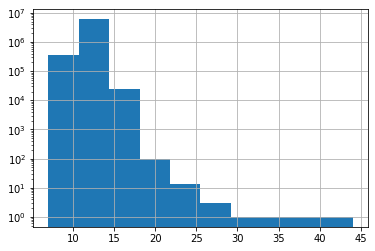

In [18]:
fig, ax = plt.subplots()
features.groupby("track_index").FT_hitPlaneCode.count().hist(ax=ax);
ax.set_yscale('log') 
# wtf?!

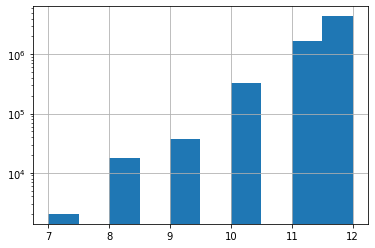

In [28]:
fig, ax = plt.subplots()
features.groupby("track_index").FT_hitPlaneCode.nunique().hist(ax=ax);
ax.set_yscale('log') 


In [13]:
data.FT_z.unique()

array([7826.099 , 7895.9   , 7966.1   , 7966.0996, 8035.901 , 8508.1   ,
       8577.9   , 8648.101 , 8717.9   , 9193.1   , 9262.899 , 9333.101 ,
       9402.9   , 8577.899 , 7895.9004, 8648.1   , 7895.8994, 7966.1006,
       9333.1   , 9262.9   , 9333.102 , 8577.898 , 8648.102 , 9262.898 ])

In [182]:
def split_test_train_with_stratification(df, stratify_column, test_size ):
    all_indices = df[stratify_column].unique().tolist()
    n_test = int(test_size * len(all_indices))
    
    train_indices = random.sample(all_indices, k=n_test)
    X_train = df[~df[stratify_column].isin(train_indices)] 
    X_test = df[df[stratify_column].isin(train_indices)]
    return X_train, X_test

In [2]:
class HitsDataset(Dataset):
    def __init__(self, hits_df):
        self.df = hits_df
        self.n_planes = 12
        self.df["track_id"]= list(zip(self.df.eventID, self.df.particle_key))
        self.target = self.df[["track_id","particle_isDown_noVelo"]].drop_duplicates("track_id")
        self.index_dict = {index:x for index, x in enumerate(self.df["track_id"].unique())}

    def __getitem__(self,index):
        features = self._extract_features(self.df[self.df.track_id == self.index_dict[index]])        
        hits_tensor = features
        
        target = self.target[self.target.track_id == self.index_dict[index]].particle_isDown_noVelo.iloc[0]        
        
        return hits_tensor,  target
        
    def __len__(self):
        return max(self.index_dict.keys())
    
    def _extract_features(self,df):
        """
        This function converts dataframe into a pytorch tensor of shape (n_planes, n_features)
        if number of planes is smaller that **n_planes** the input tensor is zero padded via adding a zero vector 
        on missing possition, e.g. if plane 3 is missing the vector of zeros will be inserted into position 3. 
        """
        df.drop_duplicates(subset=["track_id", "FT_hitPlaneCode"], keep='first', inplace=True)
        idx = pd.MultiIndex.from_product([df['track_id'].unique(), 
                                  np.arange(self.n_planes)],
                                 names=['track_id', 'FT_hitPlaneCode'])
        df = df.set_index(['track_id', 'FT_hitPlaneCode']).reindex(idx).reset_index()
        df.fillna(0., inplace=True)
        df["feature_vector"] = df[["FT_dxdy", "FT_hitzone","FT_w","FT_x"]].apply(np.array, axis=1)
        return df.groupby(["track_id"])["feature_vector"].apply(np.vstack).iloc[0]


In [3]:
chunksize = 100000
n_chunks = 75418583//chunksize
datasets_train = []
for df_chunk in tqdm(pd.read_csv("/data/work/wessex/Wessex/test/FT_hits_with_info.csv", 
                                chunksize=chunksize), leave=False, total=n_chunks ):
    datasets_train.append(HitsDataset(df_chunk))


In [4]:
def serialize_dataset(dataset):
    features_numpy = []
    target_list = []
    for i in tqdm(range(len(dataset)),position=1,leave=False ):
        item = dataset.__getitem__(i)
        features_numpy.append(item[0])
        target_list.append(item[1])  
    df = pd.DataFrame({'features':features_numpy,'target':target_list})    
    df.to_pickle("_".join(["/data/work/wessex/Wessex/test/ft_hits/ft_hits",str(tempfile.mkdtemp().split("/")[-1]),".pickle"]))
    del df, features_numpy, target_list


In [6]:
with Pool(processes=11) as p:
        with tqdm(total=len(datasets_train[:22]), position=0) as pbar:
            for i, _ in enumerate(p.imap_unordered(serialize_dataset, datasets_train[:22])):
                pbar.update()

In [7]:
import glob
hits_df = pd.concat([pd.read_pickle(path) for path in glob.glob("/data/work/wessex/Wessex/test/ft_hits/*")])

In [8]:
hits_df.head()

,features,target
0,"[[0.0, 0.0, 25.0, 221.435], [0.08748923, 0.0, ...",0
1,"[[-0.0, 1.0, 34.602074, 115.990005], [0.087489...",0
2,"[[0.0, 0.0, 34.602074, -536.89], [0.08748923, ...",0
3,"[[0.0, 0.0, 34.602074, -379.215], [0.08748923,...",0
4,"[[-0.0, 1.0, 34.602074, -440.49002], [0.087489...",0


In [14]:
torch.tensor(hits_df.target.iloc[1232])

tensor(1)

In [10]:
hits_df.to_pickle("/data/work/wessex/Wessex/test/FT_hits.pickle")

In [17]:
class HitsDataset(Dataset):
    def __init__(self, hits_df):
        self.features = hits_df.features
        self.target  = hits_df.target
        

    def __getitem__(self,index):        
        return (torch.tensor(self.features.iloc[index]), 
                torch.tensor(self.target.iloc[index]))
        
    def __len__(self):
        return len(self.features)

In [18]:
X_train, X_valid = train_test_split(hits_df, test_size=0.2, random_state=12)

In [19]:
datasets={
    "train":HitsDataset(X_train),
    "valid":HitsDataset(X_valid)
}


In [20]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=256,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=5)
}

In [21]:
    for batch in dataloaders["train"]:
        print("features", batch[0], batch[0].shape)
        print("target", batch[1], len(batch[1]))
        break

features tensor([[[-0.0000e+00,  1.0000e+00,  3.4602e+01, -4.6194e+02],
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01, -4.7501e+02],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -4.6547e+02],
         ...,
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01, -5.8593e+02],
         [-8.7489e-02,  1.0000e+00,  2.5000e+01, -5.7441e+02],
         [-0.0000e+00,  1.0000e+00,  3.4602e+01, -5.8843e+02]],

        [[-0.0000e+00,  1.0000e+00,  2.5000e+01, -3.9715e+01],
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01, -5.9297e+01],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -8.1821e+00],
         ...,
         [ 8.7489e-02,  1.0000e+00,  3.4602e+01,  2.2309e+01],
         [-8.7489e-02,  1.0000e+00,  1.8904e+01,  8.2342e+01],
         [-0.0000e+00,  1.0000e+00,  3.4602e+01,  5.8935e+01]],

        [[ 0.0000e+00,  0.0000e+00,  3.4602e+01, -1.3769e+02],
         [ 8.7489e-02,  0.0000e+00,  3.4602e+01, -1.1732e+02],
         [-8.7489e-02,  0.0000e+00,  1.4793e+01, -1.4438e+02],
         ...,


# Build a model 

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
class RNNUpgradeTracking(nn.Module):
    def __init__(self,):
        super(RNNUpgradeTracking, self).__init__()
        self.num_layers = 2
        self.hidden_size = 12
        self.batch_size = 256

        self.rnn = nn.LSTM(
            input_size= 4,
            hidden_size= self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(self.hidden_size, 2)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device)
        cell =  Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device)
        return (hidden, cell)


    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        output, self.hidden = self.rnn(inputs, self.init_hidden())
        output = self.decoder(output[:,-1,:])
        return output

In [24]:
model = RNNUpgradeTracking()
model.to(device)
model


RNNUpgradeTracking(
  (rnn): LSTM(4, 12, num_layers=2, batch_first=True)
  (decoder): Linear(in_features=12, out_features=2, bias=True)
)

In [25]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion =torch.nn.CrossEntropyLoss().to(device)

In [26]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs.float())
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

In [27]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([48, 4])
rnn.weight_hh_l0 	 torch.Size([48, 12])
rnn.bias_ih_l0 	 torch.Size([48])
rnn.bias_hh_l0 	 torch.Size([48])
rnn.weight_ih_l1 	 torch.Size([48, 12])
rnn.weight_hh_l1 	 torch.Size([48, 12])
rnn.bias_ih_l1 	 torch.Size([48])
rnn.bias_hh_l1 	 torch.Size([48])
decoder.weight 	 torch.Size([2, 12])
decoder.bias 	 torch.Size([2])


In [28]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2138

In [29]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=3)


Epoch 1/3
----------


train loss: 0.4092, train acc: 0.8541, elapsed:391.6204


valid loss: 0.4012, valid acc: 0.8560, elapsed:29.7024

Epoch 2/3
----------


train loss: 0.4020, train acc: 0.8551, elapsed:417.9155


valid loss: 0.4002, valid acc: 0.8560, elapsed:30.6179

Epoch 3/3
----------


train loss: 0.4013, train acc: 0.8551, elapsed:400.5192


valid loss: 0.3994, valid acc: 0.8560, elapsed:30.6069
training took:  1300.9839938282967


In [30]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr)

In [31]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=3)


Epoch 1/3
----------


train loss: 0.4015, train acc: 0.8551, elapsed:401.3702


valid loss: 0.3988, valid acc: 0.8560, elapsed:31.5028

Epoch 2/3
----------


train loss: 0.4000, train acc: 0.8551, elapsed:402.2940


valid loss: 0.3979, valid acc: 0.8560, elapsed:31.3695

Epoch 3/3
----------


train loss: 0.3991, train acc: 0.8551, elapsed:409.6870


valid loss: 0.3974, valid acc: 0.8560, elapsed:31.7038
training took:  1307.9292850359343


In [32]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    pred = F.softmax(output).cpu().detach().numpy()[:,1]
    fpr, tpr, thresholds = roc_curve(Y,pred )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.4f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



In [33]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


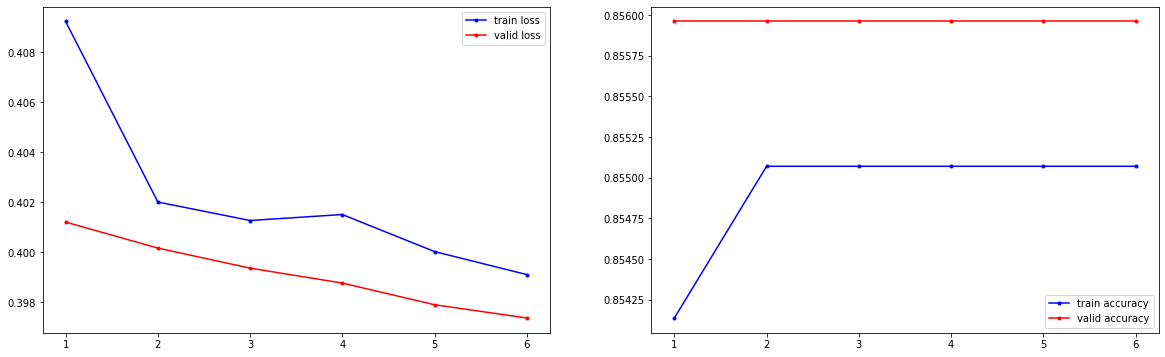

In [34]:
plot_training_classification(run_hist)

In [187]:
print_roc(model,X_valid, Y_valid )

NameError: name 'X_valid' is not defined

In [35]:
for param in model.named_parameters():
  print(param)


('rnn.weight_ih_l0', Parameter containing:
tensor([[-2.1166e-02,  2.8504e-01,  7.0119e-01,  4.1134e-03],
        [ 5.1272e-01,  1.4020e-01, -1.1521e-01, -2.1040e-01],
        [-4.8158e-01,  9.6915e-03,  2.4526e-03, -4.4403e-02],
        [-5.5780e-01,  3.5443e-01,  2.4188e-01,  2.3517e-01],
        [-1.5378e-01,  6.4636e-01,  3.7092e-01, -9.2683e-02],
        [-1.4312e-01, -3.7882e-01, -2.2075e-01, -3.4001e-01],
        [-3.2469e-01,  1.7279e-01, -4.9206e-03,  3.0934e-02],
        [ 2.4121e-01,  3.0918e-01, -2.7858e-03,  5.4739e-02],
        [-4.7485e-01,  3.9073e-01,  1.3812e-01, -1.2654e-01],
        [-8.4885e-01,  4.4782e-01,  1.6363e-01, -2.9644e-02],
        [ 7.7875e-01, -2.3120e-01, -5.2335e-01,  1.3368e-01],
        [ 8.4739e-02, -4.6857e-01, -8.1248e-01, -4.5743e-02],
        [ 1.5215e-01,  8.3031e-02,  3.3876e-01, -1.6700e-01],
        [-1.8382e-01,  2.9527e-01,  5.8262e-03,  1.6585e-01],
        [-6.4633e-01,  2.5015e-01,  4.3780e-01,  7.2508e-02],
        [-3.1719e-01,  5.05

In [36]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".RNN_1.pt")


In [37]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=15)


Epoch 1/15
----------


train loss: 0.3986, train acc: 0.8551, elapsed:391.3887


valid loss: 0.3966, valid acc: 0.8560, elapsed:31.0022

Epoch 2/15
----------


train loss: 0.3982, train acc: 0.8551, elapsed:399.8248


valid loss: 0.3969, valid acc: 0.8560, elapsed:31.4357

Epoch 3/15
----------


train loss: 0.3980, train acc: 0.8551, elapsed:401.9308


valid loss: 0.3964, valid acc: 0.8560, elapsed:31.0404

Epoch 4/15
----------


train loss: 0.3977, train acc: 0.8551, elapsed:395.9930


valid loss: 0.3960, valid acc: 0.8560, elapsed:31.5714

Epoch 5/15
----------


train loss: 0.3977, train acc: 0.8551, elapsed:399.8593


valid loss: 0.3961, valid acc: 0.8560, elapsed:31.2701

Epoch 6/15
----------


train loss: 0.3975, train acc: 0.8551, elapsed:389.8695


valid loss: 0.3956, valid acc: 0.8560, elapsed:32.3890

Epoch 7/15
----------


train loss: 0.3973, train acc: 0.8551, elapsed:396.8174


valid loss: 0.3961, valid acc: 0.8560, elapsed:32.8968

Epoch 8/15
----------


train loss: 0.3972, train acc: 0.8551, elapsed:398.0242


valid loss: 0.3954, valid acc: 0.8560, elapsed:31.4808

Epoch 9/15
----------


train loss: 0.3971, train acc: 0.8551, elapsed:398.3950


valid loss: 0.3956, valid acc: 0.8560, elapsed:31.8380

Epoch 10/15
----------


train loss: 0.3969, train acc: 0.8551, elapsed:396.4944


valid loss: 0.3950, valid acc: 0.8560, elapsed:32.6087

Epoch 11/15
----------


train loss: 0.3967, train acc: 0.8551, elapsed:390.6698


valid loss: 0.3948, valid acc: 0.8560, elapsed:33.0893

Epoch 12/15
----------


train loss: 0.3966, train acc: 0.8551, elapsed:396.6773


valid loss: 0.3948, valid acc: 0.8560, elapsed:30.4677

Epoch 13/15
----------


train loss: 0.3963, train acc: 0.8551, elapsed:388.5996


valid loss: 0.3948, valid acc: 0.8560, elapsed:32.2418

Epoch 14/15
----------


train loss: 0.3964, train acc: 0.8551, elapsed:406.3830


valid loss: 0.3954, valid acc: 0.8560, elapsed:31.2174

Epoch 15/15
----------


train loss: 0.3962, train acc: 0.8551, elapsed:393.9763


valid loss: 0.3945, valid acc: 0.8560, elapsed:32.0252
training took:  6421.485638681799


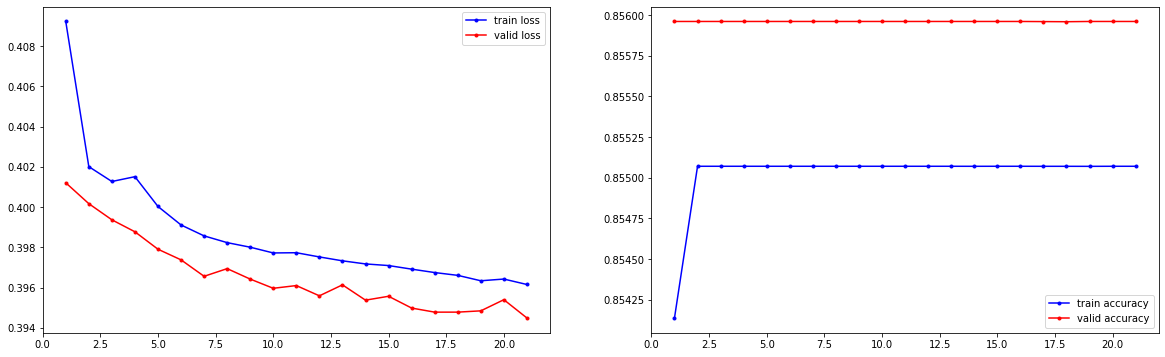

In [38]:
plot_training_classification(run_hist)